In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
from bs4 import BeautifulSoup
import json
import os
import pandas as pd, numpy as np
from xml.etree import ElementTree as ET

import cv2
import matplotlib.pyplot as plt

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
tf.__version__

'2.6.4'

In [3]:
def processing(path):
    
    data = {"file_name":{},
            "width": {},
            "height": {},
            "class_name": {},
#             "pose": {},
#             "truncated": {},
#             "difficult": {},
            "xmin": {},
            "ymin": {},
            "xmax": {},
            "ymax": {},
           }

    i = 0
    for file in os.listdir(path):
        infile_xml = open(path + '/' + file)
        tree = ET.parse(infile_xml)
        root = tree.getroot()

        for obj in root.iter('object'):
            cls_name = obj.find('name').text
#             pose = obj.find('pose').text
#             truncated = obj.find('truncated').text
#             difficult = obj.find('difficult').text

            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            data['class_name'][i] = cls_name
#             data['pose'][i] = pose
#             data['truncated'][i] = truncated
#             data['difficult'][i] = difficult
            data['xmin'][i] = xmin
            data['ymin'][i] = ymin
            data['xmax'][i] = xmax
            data['ymax'][i] = ymax

            for f in root.iter('filename'):
                data['file_name'][i] = f.text

            for s in root.iter('size'):
                width = s.find('width').text
                height = s.find('height').text

                data['width'][i] = width
                data['height'][i] = height

            i += 1
            
    return data

In [4]:
def annotation_processing(path):
    data = processing(path)

    jsonf = open("/kaggle/working/data.json", 'w')
    json.dump(data, jsonf)
    jsonf.close()

    with open("../working/data.json") as file:
        d = json.load(file)
    df = pd.DataFrame(d)
    return df

In [5]:
path = "/kaggle/input/rdd-thesis-dataset/China_Drone/China_Drone/train/annotations/xmls"

# train_img_num = round(len(os.listdir("/kaggle/input/rdd-thesis-dataset/China_Drone/China_Drone/train/images")) * 0.7)
# test_img_num = round(len(os.listdir("/kaggle/input/rdd-thesis-dataset/China_Drone/China_Drone/train/images")) * 0.15)

# train_img_list = os.listdir(path)[:train_img_num]
# test_img_list = os.listdir(path)[train_img_num:test_img_num]
# validate_img_list = os.listdir(path)[train_img_num+test_img_num: ]

annotation_df = annotation_processing(path)
annotation_df.head()

,file_name,width,height,class_name,xmin,ymin,xmax,ymax
0,China_Drone_000390.jpg,512,512,D10,234,292,493,365
1,China_Drone_000036.jpg,512,512,D10,27,307,512,359
2,China_Drone_000036.jpg,512,512,D00,102,395,136,512
3,China_Drone_000054.jpg,512,512,D10,247,224,512,276
4,China_Drone_000412.jpg,512,512,D10,1,409,193,439


In [4]:
with open("../working/data.json") as file:
    d = json.load(file)
annotation_df = pd.DataFrame(d)
cat_value = annotation_df["class_name"].astype('category').cat.codes.tolist()

annotation_df.insert(loc=4,column="class_category", value=cat_value)
# annotation_df.head()

In [10]:
img_data = []
labels = []
bboxes = []

for i in range(annotation_df.shape[0]):
    img_path = "/kaggle/input/rdd-thesis-dataset/China_Drone/China_Drone/train/images" + "/" + annotation_df["file_name"][i]
    image = cv2.imread(img_path)
    (h,w) = image.shape[:2]
    
    image = load_img(img_path, target_size=(250,250))
    image = img_to_array(image)
    
    xmin = annotation_df["xmin"][i] / w
    xmax = annotation_df["xmax"][i] / w
    ymin = annotation_df["ymin"][i] / h
    ymax = annotation_df["ymax"][i] / h
    
    
    img_data.append(image)
    labels.append(annotation_df["class_category"][i])
    bboxes.append((xmin,ymin, xmax, ymax))
    
img_data = np.array(img_data, dtype="float32") / 255.0
labels = np.array(labels)
labels = to_categorical(labels)
bboxes = np.array(bboxes, dtype="float32")

split = train_test_split(img_data, labels, bboxes,test_size=0.20, random_state=42)

(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]

In [5]:
labels

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [6]:
tf.keras.backend.clear_session()

In [11]:
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=trainImages[0].shape))
vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)

bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(labels.shape[1], activation="softmax", name="class_label")(softmaxHead)

model = Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))

losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

opt = Adam(learning_rate=1e-4)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

2023-02-03 23:28:01.566441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 23:28:01.567506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 23:28:01.743347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 23:28:01.744152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 23:28:01.744966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 250, 250, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 250, 250, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 125, 125, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [12]:
trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}

testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}

print("[INFO] training model...")
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=32,
    epochs=30,
    verbose=1)

print("[INFO] saving object detector model...")
model.save("../working/trained_model.h5", save_format="h5")

[INFO] training model...


2023-02-03 23:28:17.142506: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2304000000 exceeds 10% of free system memory.
2023-02-03 23:28:19.696728: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2304000000 exceeds 10% of free system memory.
2023-02-03 23:28:21.561103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-02-03 23:28:24.237477: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


96/96 [==============================] - 38s 211ms/step - loss: 1.5649 - bounding_box_loss: 0.0786 - class_label_loss: 1.4863 - bounding_box_accuracy: 0.5508 - class_label_accuracy: 0.3532 - val_loss: 1.3311 - val_bounding_box_loss: 0.0711 - val_class_label_loss: 1.2600 - val_bounding_box_accuracy: 0.5833 - val_class_label_accuracy: 0.4336
Epoch 2/30
96/96 [==============================] - 19s 203ms/step - loss: 1.4368 - bounding_box_loss: 0.0698 - class_label_loss: 1.3670 - bounding_box_accuracy: 0.6370 - class_label_accuracy: 0.3896 - val_loss: 1.3080 - val_bounding_box_loss: 0.0702 - val_class_label_loss: 1.2378 - val_bounding_box_accuracy: 0.5885 - val_class_label_accuracy: 0.4362
Epoch 3/30
96/96 [==============================] - 20s 210ms/step - loss: 1.3733 - bounding_box_loss: 0.0667 - class_label_loss: 1.3066 - bounding_box_accuracy: 0.6484 - class_label_accuracy: 0.4307 - val_loss: 1.2868 - val_bounding_box_loss: 0.0669 - val_class_label_loss: 1.2199 - val_bounding_box_accu

In [2]:
from tensorflow.keras.models import load_model

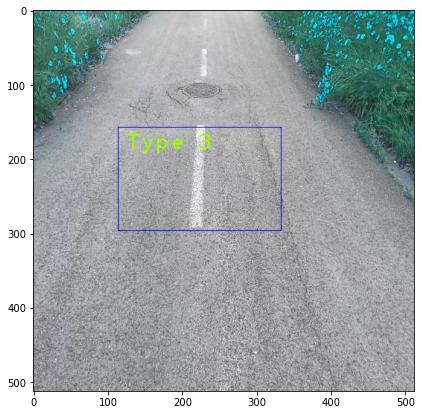

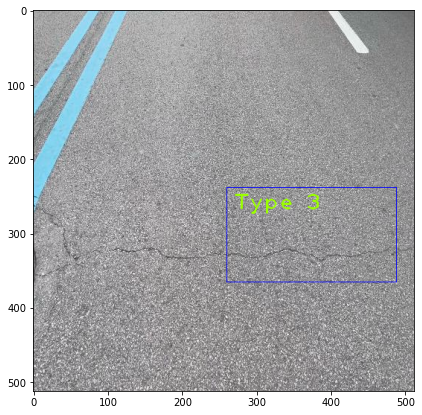

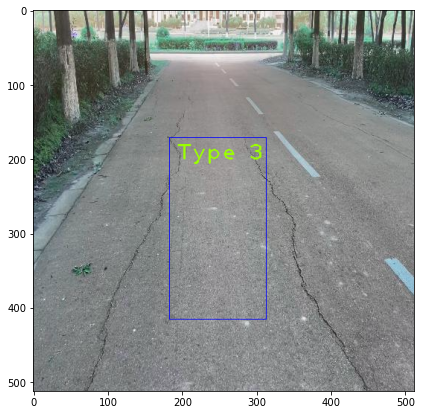

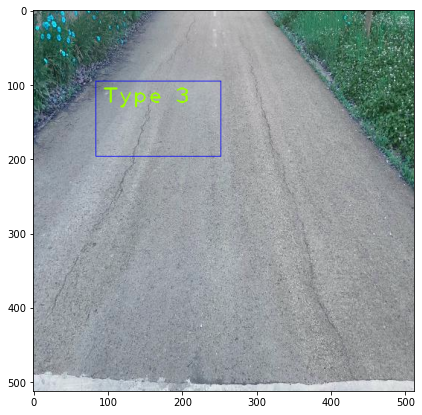

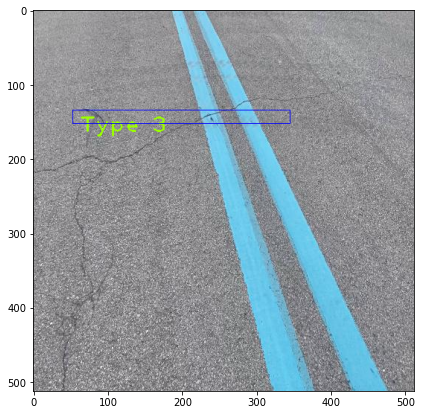

In [33]:
def draw_pred_img(img, cls_name, xmin,ymin, xmax, ymax):
    img = cv2.imread(img)
    font = cv2.FONT_HERSHEY_PLAIN
    
    (h, w) = img.shape[:2]
    
    xmin = int(xmin * w)
    xmax = int(xmax * w)
    ymin = int(ymin * h)
    ymax = int(ymax * h)
    
    
    cv2.putText(img, cls_name, (xmin+10,ymin+30), font, 2, (155,255,0), 2, cv2.LINE_8)
    cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (0,0,255), 1)
    
    return img

model = load_model("/kaggle/working/trained_model.h5")

img_path = "/kaggle/input/rdd-thesis-dataset/China_MotorBike/China_MotorBike/test/images"
for img in os.listdir(img_path)[:5]:
    image = load_img(img_path + "/" + img, target_size=(250,250))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    
    (boxpred, labelpred) = model.predict(image)
    (xmin,ymin, xmax, ymax) = boxpred
    
    for i in range(labelpred[0].shape[0]):
        if round(labelpred[0][i]) == 1:
            if i == 0:
                label = "Type 1"
            elif i == 1:
                label = "Type 2"
            elif i == 2:
                label = "Type 3"
            elif i == 3:
                label = "Type 4"
            elif i == 4:
                label = "Type 5"
            elif i == 5:
                label = "Type 6"
            else:
                pass
            break
    
    plt.figure(figsize=(18,7))
    plt.imshow(draw_pred_img(img_path + "/" + img, label, xmin,ymin, xmax, ymax))
    
    plt.show()
    
    

In [18]:
image = load_img("/kaggle/input/rdd-thesis-dataset/China_MotorBike/China_MotorBike/test/images/China_MotorBike_001977.jpg", target_size=(250,250))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
    
(boxpred, labelpred) = model.predict(image)
(xmin,ymin, xmax, ymax) = boxpred[0]

In [31]:
xmin

0.22276641

In [28]:
for i in range(labelpred[0].shape[0]):
    if round(labelpred[0][i]) == 1:
        if i == 0:
            label = "Type 1"
        elif i == 1:
            label = "Type 2"
        elif i == 2:
            label = "Type 3"
        elif i == 3:
            label = "Type 4"
        elif i == 4:
            label = "Type 5"
        elif i == 5:
            label = "Type 6"
        else:
            pass
        break
        
print(label)
labelpred[0]

Type 2


array([2.0430920e-05, 5.6565446e-01, 4.2267406e-01, 9.1968700e-03,
       3.9934966e-04, 2.0548007e-03], dtype=float32)

In [5]:
def draw_img(img_file, df):
    
    img = cv2.imread(img_file)
    img_name = img_file.split('/')[-1]
    
    img_info = df[df['file_name'] == img_name]
    
    for i in range(img_info.shape[0]):
        cls_name = img_info['class_name'][i]
        xmin = img_info['xmin'][i]
        ymin = img_info['ymin'][i]
        xmax = img_info['xmax'][i]
        ymax = img_info['ymax'][i]
        
        font = cv2.FONT_HERSHEY_PLAIN
        
        cv2.putText(img, cls_name, (xmin+10,ymin+30), font, 2, (155,255,0), 2, cv2.LINE_8)
        
        cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (0,0,255), 1)
        
    return img

In [9]:
for file in os.listdir("/kaggle/input/rdd-thesis-dataset/China_Drone/China_Drone/train/images")[:5]:
    plt.figure(figsize=(18,7))
    plt.imshow(draw_img("/kaggle/input/rdd-thesis-dataset/China_Drone/China_Drone/train/images/" + file, df))
    plt.axis('off')
    plt.show()

In [2]:
# mask = img.copy()
# mask[:] = 155

# xmin = df[(df["file_name"]== img_path.split('/')[-1]) & (df["class_name"] == "D10")]["xmin"][0]
# ymin = df[(df["file_name"]== img_path.split('/')[-1]) & (df["class_name"] == "D10")]["ymin"][0]
# xmax = df[(df["file_name"]== img_path.split('/')[-1]) & (df["class_name"] == "D10")]["xmax"][0]
# ymax = df[(df["file_name"]== img_path.split('/')[-1]) & (df["class_name"] == "D10")]["ymax"][0]

# num_channel = 1 if len(mask.shape) == 2 else mask.shape[2]
# mask_img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color=(255,) * num_channel)
# plt.imshow(mask_img)

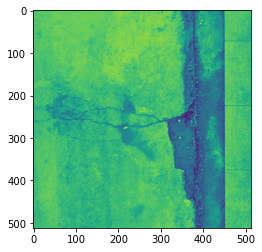

In [51]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

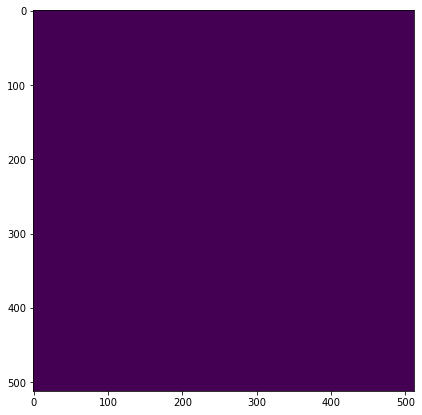

In [39]:
plt.figure(figsize=(18,7))
plt.imshow(th)

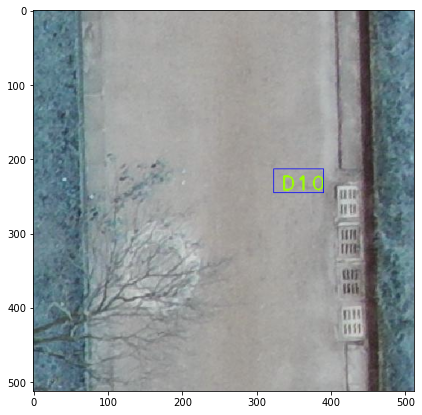

In [40]:
plt.figure(figsize=(18,7))
plt.imshow(draw_img(img_path, df))